<a href="https://colab.research.google.com/github/KIIIIT00/B3_Spring/blob/main/MNIST_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **B3_Spring** ###


In [1]:
# Install necessary libraries
!pip install torch torchvision tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tensorflow.keras.datasets import mnist
import math
import matplotlib.pyplot as plt
import numpy as np

### Class and method definitions ###
* MNIST_CNN : CNN class for classifying handwritten digits
  * forward : Performs forward propagation
  * save_model : Saves the model
  * load_model : Loads the model

* show_mnist_comparison : Displays the original images, labels, and predictions

In [4]:
# Define the CNN model
class MNIST_CNN(nn.Module):
  def __init__(self):
    super(MNIST_CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=16,
                           kernel_size=3,
                           padding=1)
    self.conv2 = nn.Conv2d(in_channels=16,
                           out_channels=32,
                           kernel_size=3,
                           padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(32 * 14 * 14, 128)
    self.fc2 = nn.Linear(128, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  def save_model(self, model_name):
    """
    Save this model

    Parameters:
      model_name (str): The name of the model to save
    """
    model_path = f'{model_name}.pth'
    torch.save(self.state_dict(), model_path)

  def load_model(self, model_name):
    """
      Load a saved model

    Parameters:
      model_name (str): The name of the model to load
    """
    model_path = f'{model_name}.pth'
    if os.path.exists(model_path):
      self.load_state_dict(torch.load(model_path))
      print("Model loaded successfully")
    else:
      print("Model not found")

In [5]:
def show_mnist_comparison(originals, images, labels, predictions):
    """ 元の画像・ラベル・予測結果を比較表示する関数 """
    num_images = len(images)
    cols = min(5, num_images)  # Display up to 5 images per row
    rows = math.ceil(num_images / cols) * 2  # Need twice the number of rows for comparison

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    fig.subplots_adjust(hspace=0.5) # Increase spacing between images and titles

    for i in range(num_images):
        # Original images (First row)
        ax = axes[i // cols * 2, i % cols]
        orig_img = originals[i].cpu().numpy().squeeze()
        ax.imshow(orig_img, cmap="gray")
        ax.set_title(f"Original Label: {labels[i].item()}", fontsize=10, pad=8)  # Adjust padding using `pad`
        ax.axis("off")

        # Predicted images (Second row)
        ax = axes[i // cols * 2 + 1, i % cols]
        pred_img = images[i].cpu().numpy().squeeze()
        ax.imshow(pred_img, cmap="gray")
        ax.set_title(f"Pred Label: {predictions[i].item()}", fontsize=10, pad=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
your_name = "taro"

### 実行セル ###

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1) / 255.0
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1) / 255.0
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create model
model = MNIST_CNN().to(device)


# Set loss function and optimizer
loss_functions = {
    "crossentropy": nn.CrossEntropyLoss(),
    "mse": nn.MSELoss()
}
selected_loss = "crossentropy"
criterion = loss_functions[selected_loss]

"""
[TODO]
Try changing the parameters !!!
"""
learning_rate = 0.001
momentum = 0.9
optimizers = {
    "sgd": optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum),
    "adam": optim.Adam(model.parameters(), lr=learning_rate),
    "adamw": optim.AdamW(model.parameters(), lr=learning_rate),
    "adagrad": optim.Adagrad(model.parameters(), lr=learning_rate),
    "nadam": optim.NAdam(model.parameters(), lr=learning_rate)
}
selected_optimizer = "adam"
optimizer = optimizers[selected_optimizer]

# make logs dir
if not os.path.exists("logs"):
    os.makedirs("logs")

# save settings
epochs = 5
settings_path = f"logs/settings_by_{your_name}.txt"
with open(settings_path, "w") as f:
    f.write(f"Device: {device}\n")
    f.write(f"Batch Size: {batch_size}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Optimizer: {selected_optimizer}\n")
    f.write(f"Loss Function: {selected_loss}\n")
    f.write(f"Epochs: {epochs}\n")

# Training loop
loss_log_path = f"logs/loss_log_by_{your_name}.txt"
with open(loss_log_path, "w") as loss_file:
  for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        if selected_loss == "mse":
          labels = torch.nn.functional.one_hot(labels, num_classes=10).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")
    # save loss
    loss_file.write(f"Epoch {epoch+1}: {avg_loss:.4f}\n")

# Save model
model.save_model("mnist_cnn")

# Evaluate model
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
accuracy_log_path = f"logs/accuracy_log_by_{your_name}.txt"
with open(accuracy_log_path, "w") as acc_file:
    acc_file.write(f"Test Accuracy: {accuracy:.2f}%\n")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5, Loss: 0.1918
Epoch 2/5, Loss: 0.0525
Epoch 3/5, Loss: 0.0348
Epoch 4/5, Loss: 0.0244
Epoch 5/5, Loss: 0.0181
Test Accuracy: 98.97%


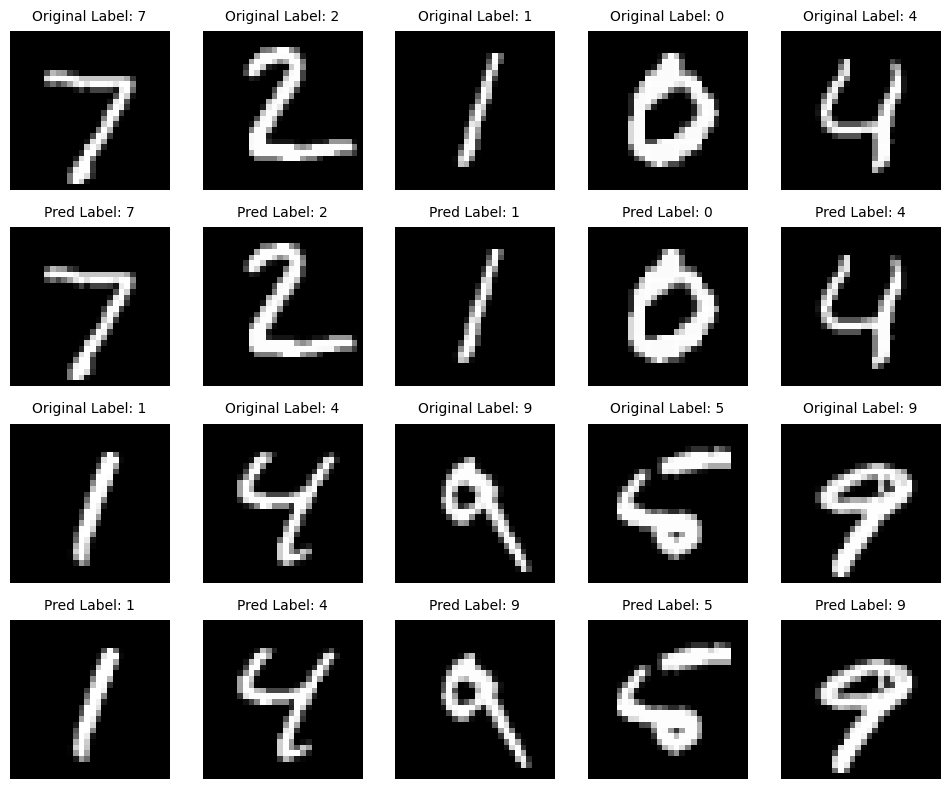

In [8]:
num_images = 10
originals, labels = zip(*[test_dataset[i] for i in range(num_images)])
images = torch.stack(originals).to(device)

model.eval()

# Batch processing
images = images.to(device)

# Prediction
with torch.no_grad():
    outputs = model(images)
    predictions = outputs.argmax(dim=1)

# Display images, Labels, and predictions
show_mnist_comparison(originals, images, labels, predictions)